In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Once data has finished processing, load data from folder structure
# text-data/
# ├─ advertisement/
# ├─ email/
# ├─ invoice/
# ....
data = load_files('../text-data', encoding='utf-8', decode_error='ignore')

X = data.data               
y = data.target             
class_names = data.target_names 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# vectorize text using TF-IDF
vectorizer = TfidfVectorizer(
    # this is all first pass so might want to update after check in
    # limit vocab
    max_features=5000,
    # ignore terms that appear in fewer than 2 documents     
    min_df=2,               
    # ignore terms that appear in more than 80% of documents
    max_df=0.8,
    # using unigrams and bigrams             
    ngram_range=(1, 2), 
    # removing common English words    
    stop_words='english'
)

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [3]:
# train baseline Logistic Regression
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_vectors, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [4]:
# eval on test set
y_pred = base_model.predict(X_test_vectors)
print(f"Test Accuracy: {base_model.score(X_test_vectors, y_test)}\n")

print("Baseline Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test Accuracy: 0.742

Baseline Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.85      0.78      0.81        64
                budget       0.74      0.78      0.76        64
                 email       0.95      0.90      0.92        60
           file_folder       0.50      0.76      0.60        72
                  form       0.77      0.66      0.71        62
           handwritten       0.77      0.57      0.65        65
               invoice       0.80      0.77      0.79        48
                letter       0.74      0.62      0.67        63
                  memo       0.73      0.71      0.72        66
          news_article       0.73      0.75      0.74        61
          presentation       0.72      0.61      0.66        70
         questionnaire       0.93      0.66      0.77        65
                resume       0.95      0.95      0.95        62
scientific_publication       0.74      0.91      

In [5]:
# tuning with grid search

# chains vectorizer and model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    # max vocab size
    'tfidf__max_features': [3000, 5000, 7000],
    # unigrams only, unigrams + bigrams, unigrams + bigrams + trigrams
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    # min document frequency - removes rare words
    'tfidf__min_df': [2, 3, 5],
    # max document frequency - removes common words
    'tfidf__max_df': [0.7, 0.8, 0.9],
    # inverse regularization strength
    'clf__C': [0.1, 1, 10],
    # optimization algo
    'clf__solver': ['saga', 'lbfgs'],
    # L2 regularization
    'clf__penalty': ['l2']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'clf__penalty': ['l2'], 'clf__solver': ['saga', 'lbfgs'], 'tfidf__max_df': [0.7, 0.8, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [6]:
# evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print(f"Tuned Test Accuracy: {best_model.score(X_test, y_test)}")

print("Tuned Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

Tuned Test Accuracy: 0.75
Tuned Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.78      0.81      0.79        64
                budget       0.82      0.84      0.83        64
                 email       0.95      0.88      0.91        60
           file_folder       0.50      0.74      0.60        72
                  form       0.77      0.71      0.74        62
           handwritten       0.75      0.58      0.66        65
               invoice       0.80      0.83      0.82        48
                letter       0.70      0.60      0.65        63
                  memo       0.74      0.74      0.74        66
          news_article       0.78      0.74      0.76        61
          presentation       0.69      0.59      0.64        70
         questionnaire       0.93      0.66      0.77        65
                resume       0.97      0.97      0.97        62
scientific_publication       0.76      0.88     

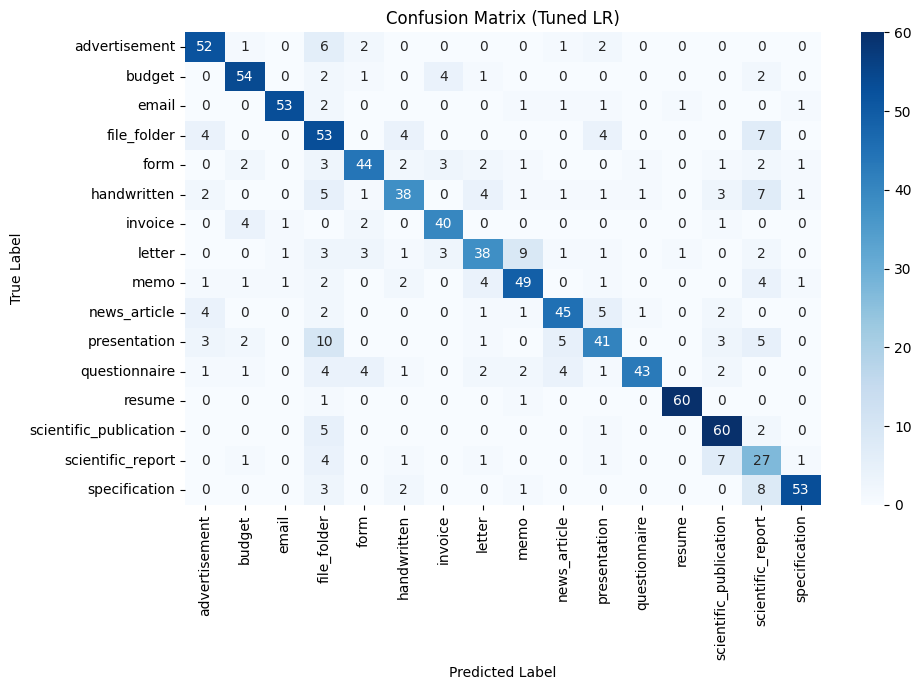

<Figure size 640x480 with 0 Axes>

In [7]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix (Tuned LR)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

plt.savefig('confusion_matrix_tuned_lr.png')

In [8]:
# feature analysis
tuned_vectorizer = best_model.named_steps['tfidf']
tuned_clf = best_model.named_steps['clf']
feature_names = np.array(tuned_vectorizer.get_feature_names_out())

top_n = 10
for i, class_label in enumerate(class_names):
    # get and print top weights and features
    coefficient = tuned_clf.coef_[i]
    top_indices = np.argsort(coefficient)[-top_n:]
    top_features = feature_names[top_indices]
    top_weights = coefficient[top_indices]
    print(f"Top features for class '{class_label}':")
    for feature, weight in zip(top_features, top_weights):
        print(f"{feature}: {weight:.4f}")

Top features for class 'advertisement':
come: 3.5774
taste: 3.6024
camel: 3.6402
music: 3.9778
web: 4.0044
mg: 4.1063
surgeon: 4.1733
advertisement: 4.5554
camels: 4.8981
Top features for class 'budget':
balance: 3.3417
kool: 3.4357
media: 3.4677
65: 3.6194
month: 3.6384
institute: 4.0215
00: 4.1497
000: 4.1856
budget: 5.0002
total: 6.6108
Top features for class 'email':
2001: 2.8923
thanks: 2.9581
karen: 3.1292
fw: 3.5206
message: 3.7398
joanne: 3.9639
pm: 4.2678
cc: 4.8524
sent: 7.9130
subject: 10.3524
Top features for class 'file_folder':
ets: 1.9714
ctr: 2.0220
207: 2.0295
silva: 2.0549
engineering: 2.2052
manual: 2.2113
fig: 2.2213
ph: 2.3030
boy: 2.3170
correspondence: 3.4539
Top features for class 'form':
yes: 3.5627
form: 3.5837
zn: 3.6067
pages: 3.6250
telefax: 3.6349
facsimile: 3.9639
sheet: 3.9940
datum: 4.8253
fax: 5.6156
date: 7.2204
Top features for class 'handwritten':
mrs: 3.1799
received: 3.1980
camel: 3.2254
concern: 3.3786
rd: 3.4517
salem: 3.6751
dear: 4.0673
coupon

In [9]:
# save model
import joblib
joblib.dump(best_model, 'lr_tuned.pkl')

['lr_tuned.pkl']